# Urban scaling and coronavirus #

This notebook is a replication attempt of Stier et al.'s preprint on Arxiv [1]. This notebook brings together MSA definitions and census data to allow demographic calculations for MSAs in relation to the coronavirus outbreak. The MSAs are a county-level unit delineated by the Census Bureau (see https://www.census.gov/programs-surveys/metro-micro/about/delineation-files.html). The coronavirus outbreak data are provided by USAFacts (https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/, last downloaded March 25th, 2020 14:34 EDT).

.. [1] Andrew J Stier, Marc G. Berman, and Luis M. A. Bettencourt. March 23rd, 2020. COVID-19 attack rate increases with city size. arXiv:2003.10376v1 [q-bio.PE]


In [1]:
#import key packages
import numpy as np
import pandas
import os
import sys
import datetime #the covid dataset uses datetimes as column indices
import scipy.stats
import matplotlib.pyplot as plt

In [2]:
#Load the datasets: the MSA delineations, the ACS 2018 population estimates, and the USAFacts Coronavirus dataset
msas = pandas.read_excel(r'data\US Census\MSA Delineations\Core based and combined\list1_Sep_2018.xls',header=2)
pop = pandas.read_excel(r'data\\US Census\\Population\\co-est2018-alldata.xls')
covid = pandas.read_excel(r'data\Coronavirus\USAFacts\covid_confirmed_usafacts.xls')
deaths = pandas.read_excel(r'data\Coronavirus\USAFacts\covid_deaths_usafacts.xls')

In [3]:
#print(msas.iloc[0])
#print(pop.iloc[0])
#print(covid.iloc[0])
#msas['CBSA Code'].unique()

In [4]:
#Assemble the state, metro/micro areas, pop data, and covid cases
data = []
popnotfound = []
covidnotfound = []
covidnotincl = []
dateStart = datetime.datetime(2020, 3, 13, 0, 0)
dateEnd = datetime.datetime(2020, 3, 19, 0, 0) #INCLUSIVE
days = (dateEnd - dateStart).days+1
col_names = ['CBSA','Title','MetroMicro','Pop2018','COVIDEnd','AttackRate','r']
#We have to leave out Puerto Rico because it is not in the census data
for cbsa in msas.loc[(msas['FIPS State Code'] != 72) & (msas.index <= 1914)]['CBSA Code'].unique():
    #Get the MSA information
    #cbsa = '10740' #ABQ metro for testing
    counties = msas.loc[msas['CBSA Code'] == cbsa]
    row = [cbsa,counties.loc[counties.index[0]]['CBSA Title'],counties.loc[counties.index[0]]['Metropolitan/Micropolitan Statistical Area']]
    #for all state and county codes, go through and select the relevant pop data
    pop_total = 0
    covid_last = 0
    covid_series = [0]*days #This stores just cases, not people who died
    #Loop through every constituent county to get the population as well as the COVID cases
    for s, c in zip(counties['FIPS State Code'],counties['FIPS County Code']):
        fips = int(s*1000 + c) #str(int(s)) + '0'*(3-len(str(int(c))))+str(int(c))
        if any((pop.STATE == int(s)) & (pop.COUNTY == int(c))):
            pop_total += int(pop.loc[(pop.STATE == int(s)) & (pop.COUNTY == int(c))]['POPESTIMATE2018'])
        else:
            print(str(fips) + ' was not found in the ACS data.')
            popnotfound.append(fips)
        if any(fips == covid.countyFIPS):
            covid_last += int(sum(covid.loc[(covid.countyFIPS == fips)][dateEnd]))-int(sum(deaths.loc[(deaths.countyFIPS == fips)][dateEnd]))
            for i,d in zip(range(days),pandas.date_range(dateStart,dateEnd)):
                covid_series[i] += int(sum(covid.loc[(covid.countyFIPS == fips)][d])) - int(sum(deaths.loc[(deaths.countyFIPS == fips)][d]))
        else:
            #print(str(fips) + ' was not found in the COVID data.')
            covidnotfound.append(fips)
    row.append(pop_total)
    row.append(covid_last)
    #Now calculate the r
    if (covid_series[-1] <= 3) or (covid_series[0]<=0):
        print(row[1] + ' had too few cases for inclusion')
        covidnotincl.append(cbsa)
        row.append(np.nan)
        row.append(np.nan)
    else:
        #normalize the covid_series so that the March 13th data is 1
        covid_series = [cs * 1. / covid_series[0] for cs in covid_series]
        #run a regression
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(range(days),[np.log(cs) for cs in covid_series])
        row.append(slope)
        row.append(r_value)
    data.append(row)
df = pandas.DataFrame(data,columns=col_names)



Aberdeen, SD had too few cases for inclusion
Aberdeen, WA had too few cases for inclusion
Abilene, TX had too few cases for inclusion
Ada, OK had too few cases for inclusion
Adrian, MI had too few cases for inclusion
Alamogordo, NM had too few cases for inclusion
Albemarle, NC had too few cases for inclusion
Albert Lea, MN had too few cases for inclusion
Albertville, AL had too few cases for inclusion
Alexander City, AL had too few cases for inclusion
Alexandria, LA had too few cases for inclusion
Alexandria, MN had too few cases for inclusion
Alice, TX had too few cases for inclusion
Alma, MI had too few cases for inclusion
Alpena, MI had too few cases for inclusion
Altoona, PA had too few cases for inclusion
Altus, OK had too few cases for inclusion
Amarillo, TX had too few cases for inclusion
Americus, GA had too few cases for inclusion
Ames, IA had too few cases for inclusion
Amsterdam, NY had too few cases for inclusion
Andrews, TX had too few cases for inclusion
Angola, IN had to

C:\Users\drewc\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log
C:\Users\drewc\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2449: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
C:\Users\drewc\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\drewc\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\drewc\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Atlantic City-Hammonton, NJ had too few cases for inclusion
Atmore, AL had too few cases for inclusion
Auburn, IN had too few cases for inclusion
Auburn, NY had too few cases for inclusion
Auburn-Opelika, AL had too few cases for inclusion
Augusta-Richmond County, GA-SC had too few cases for inclusion
Augusta-Waterville, ME had too few cases for inclusion
Austin, MN had too few cases for inclusion
Bainbridge, GA had too few cases for inclusion
Bakersfield, CA had too few cases for inclusion
Bangor, ME had too few cases for inclusion
Baraboo, WI had too few cases for inclusion
Bardstown, KY had too few cases for inclusion
Barnstable Town, MA had too few cases for inclusion
Barre, VT had too few cases for inclusion
Bartlesville, OK had too few cases for inclusion
Batavia, NY had too few cases for inclusion
Batesville, AR had too few cases for inclusion
Battle Creek, MI had too few cases for inclusion
Bay City, MI had too few cases for inclusion
Bay City, TX had too few cases for inclusio

El Dorado, AR had too few cases for inclusion
Elizabeth City, NC had too few cases for inclusion
Elizabethtown-Fort Knox, KY had too few cases for inclusion
Elk City, OK had too few cases for inclusion
Elkhart-Goshen, IN had too few cases for inclusion
Elkins, WV had too few cases for inclusion
Elko, NV had too few cases for inclusion
Elmira, NY had too few cases for inclusion
El Paso, TX had too few cases for inclusion
Emporia, KS had too few cases for inclusion
Enid, OK had too few cases for inclusion
Enterprise, AL had too few cases for inclusion
Erie, PA had too few cases for inclusion
Escanaba, MI had too few cases for inclusion
Española, NM had too few cases for inclusion
Eufaula, AL-GA had too few cases for inclusion
Eugene-Springfield, OR had too few cases for inclusion
Eureka-Arcata, CA had too few cases for inclusion
Evanston, WY had too few cases for inclusion
Evansville, IN-KY had too few cases for inclusion
Fairbanks, AK had too few cases for inclusion
Fairfield, IA had to

Knoxville, TN had too few cases for inclusion
Laconia, NH had too few cases for inclusion
La Crosse-Onalaska, WI-MN had too few cases for inclusion
Lafayette-West Lafayette, IN had too few cases for inclusion
La Grande, OR had too few cases for inclusion
LaGrange, GA-AL had too few cases for inclusion
Lake Charles, LA had too few cases for inclusion
Lake City, FL had too few cases for inclusion
Lake Havasu City-Kingman, AZ had too few cases for inclusion
Lakeland-Winter Haven, FL had too few cases for inclusion
Lamesa, TX had too few cases for inclusion
Lancaster, PA had too few cases for inclusion
Laramie, WY had too few cases for inclusion
Laredo, TX had too few cases for inclusion
Las Cruces, NM had too few cases for inclusion
Las Vegas, NM had too few cases for inclusion
Laurel, MS had too few cases for inclusion
Laurinburg, NC had too few cases for inclusion
Lawrence, KS had too few cases for inclusion
Lawrenceburg, TN had too few cases for inclusion
Lawton, OK had too few cases f

Peoria, IL had too few cases for inclusion
Peru, IN had too few cases for inclusion
Pierre, SD had too few cases for inclusion
Pinehurst-Southern Pines, NC had too few cases for inclusion
Pittsburg, KS had too few cases for inclusion
Plainview, TX had too few cases for inclusion
Platteville, WI had too few cases for inclusion
Plattsburgh, NY had too few cases for inclusion
Plymouth, IN had too few cases for inclusion
Pocatello, ID had too few cases for inclusion
Point Pleasant, WV-OH had too few cases for inclusion
Ponca City, OK had too few cases for inclusion
Pontiac, IL had too few cases for inclusion
Poplar Bluff, MO had too few cases for inclusion
Portales, NM had too few cases for inclusion
Port Angeles, WA had too few cases for inclusion
Port Lavaca, TX had too few cases for inclusion
Port St. Lucie, FL had too few cases for inclusion
Portsmouth, OH had too few cases for inclusion
Pottsville, PA had too few cases for inclusion
Prescott Valley-Prescott, AZ had too few cases for i

Washington Court House, OH had too few cases for inclusion
Waterloo-Cedar Falls, IA had too few cases for inclusion
Watertown, SD had too few cases for inclusion
Watertown-Fort Atkinson, WI had too few cases for inclusion
Watertown-Fort Drum, NY had too few cases for inclusion
Wauchula, FL had too few cases for inclusion
Wausau-Weston, WI had too few cases for inclusion
Waycross, GA had too few cases for inclusion
Weatherford, OK had too few cases for inclusion
Weirton-Steubenville, WV-OH had too few cases for inclusion
Wenatchee, WA had too few cases for inclusion
West Plains, MO had too few cases for inclusion
West Point, MS had too few cases for inclusion
Wheeling, WV-OH had too few cases for inclusion
Whitewater, WI had too few cases for inclusion
Wichita, KS had too few cases for inclusion
Wichita Falls, TX had too few cases for inclusion
Williamsport, PA had too few cases for inclusion
Williston, ND had too few cases for inclusion
Willmar, MN had too few cases for inclusion
Wilmi

Correlation: 0.179763, p-value: 0.045739, slope: 0.076340


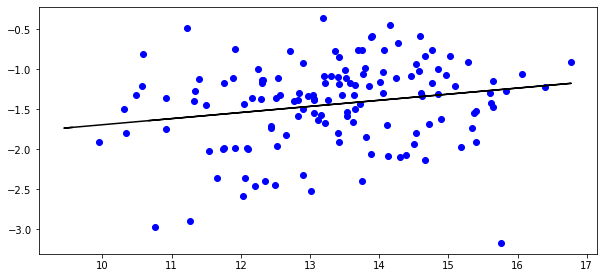

In [5]:
#Plot the chart from figure 1a
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(2,1,1)
points, = ax.plot([np.log(x) for x in df.Pop2018],[np.log(y) for y in df.AttackRate],'bo')

#Now run a linear regression 
#Only include those where an attack rate could be esitmated and its a Metropolitan Area (not Micro)
which = df.index[(pandas.isna(df.AttackRate)==False) & (df.MetroMicro == 'Metropolitan Statistical Area')] 
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress([np.log(x) for x in df.Pop2018[which]],[np.log(y) for y in df.AttackRate[which]])
line, = ax.plot([np.log(x) for x in df.Pop2018],[np.log(x)*slope + intercept for x in df.Pop2018],'k-')
print('Correlation: %f, p-value: %f, slope: %f' % (r_value,p_value,slope))

124